# Libraries

In [141]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import dask.dataframe as dd

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

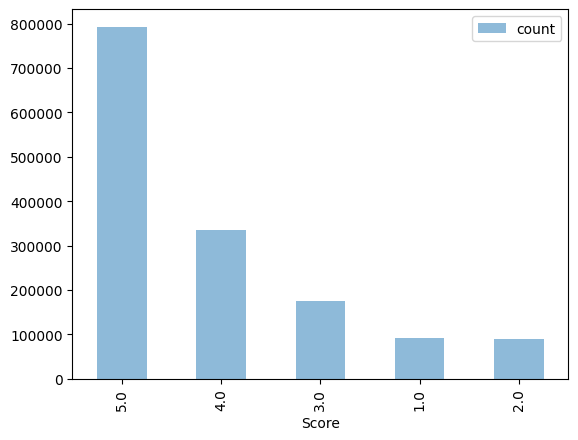


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [142]:
trainingSet = dd.read_csv("train.csv").compute()
testingSet = dd.read_csv("test.csv").compute()

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [143]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
from textblob import TextBlob

def add_features_to(df, include_sentiment=True):
    # Handle missing values in 'HelpfulnessNumerator' and 'HelpfulnessDenominator'
    if 'HelpfulnessNumerator' in df.columns and 'HelpfulnessDenominator' in df.columns:
        df['HelpfulnessNumerator'] = df['HelpfulnessNumerator'].fillna(0)
        df['HelpfulnessDenominator'] = df['HelpfulnessDenominator'].fillna(1)  # Avoid division by zero
        df['HelpfulnessRatio'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
        df = df.drop(columns=['HelpfulnessNumerator', 'HelpfulnessDenominator'])

    # Handle missing values in the 'Text' column
    df['Text'] = df['Text'].fillna('')

    # Vectorized ReviewWordCount and ReviewCharCount
    df['ReviewWordCount'] = df['Text'].str.split().str.len()
    df['ReviewCharCount'] = df['Text'].str.len()

    # Optional Sentiment Analysis Features
    if include_sentiment:
        def get_sentiment(text):
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity

        df[['Polarity', 'Subjectivity']] = df['Text'].apply(lambda x: pd.Series(get_sentiment(x)))

    # Additional Length and Uniqueness Features
    df['AvgWordLength'] = df['ReviewCharCount'] / (df['ReviewWordCount'] + 1e-5)  # Avoid div by zero
    df['UniqueWordCount'] = df['Text'].str.split().apply(set).str.len()
    df['UniqueWordRatio'] = df['UniqueWordCount'] / (df['ReviewWordCount'] + 1e-5)

    # Helpfulness Flag
    df['IsHelpful'] = (df['HelpfulnessRatio'] >= 0.5).astype(int)

    # Grouped Statistics for Product and Reviewer
    if 'ProductId' in df.columns and 'Score' in df.columns:
        product_stats = df.groupby('ProductId')['Score'].agg(
            ProductAvgRating='mean', ProductReviewCount='count'
        )
        df = df.merge(product_stats, on='ProductId', how='left')

    if 'UserId' in df.columns and 'Score' in df.columns:
        reviewer_stats = df.groupby('UserId')['Score'].agg(
            ReviewerAvgRating='mean', ReviewerReviewCount='count'
        )
        df = df.merge(reviewer_stats, on='UserId', how='left')

    # Add interaction terms
    df['HelpfulnessRatio_x_Polarity'] = df['HelpfulnessRatio'] * df['Polarity']
    df['HelpfulnessRatio_x_Subjectivity'] = df['HelpfulnessRatio'] * df['Subjectivity']
    df['Polarity_x_ReviewerReviewCount'] = df['Polarity'] * df['ReviewerReviewCount']

    # Normalize Numeric Metadata Features
    numeric_features = [
        'HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount', 'AvgWordLength', 
        'UniqueWordRatio', 'Polarity', 'Subjectivity', 'ProductAvgRating', 
        'ProductReviewCount', 'ReviewerAvgRating', 'ReviewerReviewCount',
        'HelpfulnessRatio_x_Polarity', 'HelpfulnessRatio_x_Subjectivity', 
        'Polarity_x_ReviewerReviewCount'
    ]
    
    # Check if numeric features exist before scaling
    available_features = [feat for feat in numeric_features if feat in df.columns]
    scaler = StandardScaler()
    df[available_features] = scaler.fit_transform(df[available_features].fillna(0))

    # Drop unused columns
    df = df.drop(['Time'], axis=1, errors='ignore')
    
    return df

In [162]:
# Load the feature extracted files if they've already been generated
if exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
if exists('X_submission.csv'):
    X_submission = pd.read_csv("X_submission.csv")

else:
    # Step 1: Apply feature engineering to the entire trainingSet
    full_train_with_features = add_features_to(trainingSet)

    # Step 2: Sample 20% from the engineered full_train_with_features to create X_train
    sampled_trainingSet = full_train_with_features.sample(frac=0.20, random_state=42)
    X_train = sampled_trainingSet  # This is used for model training

    # Step 3: Create X_submission by merging with testingSet on 'Id'
    X_submission = pd.merge(full_train_with_features, testingSet, left_on='Id', right_on='Id', how='right')
    X_submission = X_submission.drop(columns=['Score_x'], errors='ignore').rename(columns={'Score_y': 'Score'})

    # Step 4: Save processed X_train and X_submission for future use
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

In [163]:
# Add squared terms to match X_train
if 'HelpfulnessRatio' in X_submission.columns:
    X_submission['HelpfulnessRatio_sq'] = X_submission['HelpfulnessRatio'] ** 2
if 'Polarity' in X_submission.columns:
    X_submission['Polarity_sq'] = X_submission['Polarity'] ** 2
if 'ReviewerReviewCount' in X_submission.columns:
    X_submission['ReviewerReviewCount_sq'] = X_submission['ReviewerReviewCount'] ** 2
if 'ProductAvgRating' in X_submission.columns:
    X_submission['ProductAvgRating_sq'] = X_submission['ProductAvgRating'] ** 2

# Step 3: Save the updated X_submission with polynomial terms
X_submission.to_csv("X_submission.csv", index=False)

In [164]:
# Add squared terms to match X_train
if 'HelpfulnessRatio' in X_train.columns:
    X_train['HelpfulnessRatio_sq'] = X_train['HelpfulnessRatio'] ** 2
if 'Polarity' in X_train.columns:
    X_train['Polarity_sq'] = X_train['Polarity'] ** 2
if 'ReviewerReviewCount' in X_train.columns:
    X_train['ReviewerReviewCount_sq'] = X_train['ReviewerReviewCount'] ** 2
if 'ProductAvgRating' in X_train.columns:
    X_train['ProductAvgRating_sq'] = X_train['ProductAvgRating'] ** 2

# Step 3: Save the updated X_train with polynomial terms
X_train.to_csv("X_train.csv", index=False)

In [165]:
X_train.columns

Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'Score',
       'HelpfulnessRatio', 'ReviewWordCount', 'ReviewCharCount', 'Polarity',
       'Subjectivity', 'AvgWordLength', 'UniqueWordCount', 'UniqueWordRatio',
       'IsHelpful', 'ProductAvgRating', 'ProductReviewCount',
       'ReviewerAvgRating', 'ReviewerReviewCount',
       'HelpfulnessRatio_x_Polarity', 'HelpfulnessRatio_x_Subjectivity',
       'Polarity_x_ReviewerReviewCount', 'HelpfulnessRatio_sq', 'Polarity_sq',
       'ReviewerReviewCount_sq', 'ProductAvgRating_sq'],
      dtype='object')

# Data Processing-- Model Building

TF-IDF Vectorization

In [166]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import pandas as pd

def TFIDF_Vectorization(df):
    # Fill NaNs and concatenate 'Text' and 'Summary' columns
    df['Text'] = df['Text'].fillna('')
    df['Summary'] = df['Summary'].fillna('')
    df['Combined_Text'] = df['Text'] + " " + df['Summary']
    
    # Create TF-IDF vectorizer and fit it on the 'Combined_Text' column
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10000, min_df=10, max_df=0.7)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['Combined_Text'])
    print("TF-IDF vectorizer fitting completed!")
    return tfidf_matrix

def svd(matrix):
    # Apply Truncated SVD to reduce the dimensionality of the TF-IDF matrix
    n_components = 100  # You can adjust this number as needed
    svd = TruncatedSVD(n_components=n_components, random_state=42)  
    reduced = svd.fit_transform(matrix)
    print(f"Dimensionality reduced to {n_components} components using Truncated SVD.")
    return reduced

In [167]:
# Step 1: Generate the TF-IDF matrix and apply SVD
tfidf_matrix = TFIDF_Vectorization(X_train)
tfidf_reduced = svd(tfidf_matrix)

# Step 2: Convert the reduced TF-IDF matrix to a DataFrame
tfidf_features = [f'TFIDF_{i}' for i in range(tfidf_reduced.shape[1])]  # Create column names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=tfidf_features, index=X_train.index)

# Step 3: Concatenate the reduced TF-IDF features back into X_train
X_train = pd.concat([X_train.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Now X_train includes the vectorized text columns as TF-IDF features
print("X_train with TF-IDF features is procssed")

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.
X_train with TF-IDF features is procssed


In [168]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Define Metadata Features to Include
numeric_metadata_features = [
    'HelpfulnessRatio', 'ProductAvgRating', 'ProductReviewCount', 'ReviewerAvgRating', 'Polarity', 'Subjectivity',
    'HelpfulnessRatio_x_Polarity', 'HelpfulnessRatio_x_Subjectivity', 
    'Polarity_x_ReviewerReviewCount', 'ReviewWordCount'  # Interaction terms already added
]

# Step 2: Select and Scale All Features
# Combine numeric metadata and TF-IDF features
numeric_metadata_df = X_train[numeric_metadata_features]  # Use existing features in X_train
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=[f"TFIDF_{i}" for i in range(tfidf_reduced.shape[1])])

# Concatenate metadata and TF-IDF reduced DataFrames
X_combined = pd.concat([numeric_metadata_df.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Apply StandardScaler to all features in X_combined
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# Convert the scaled array back to a DataFrame
X_scaled_df = pd.DataFrame(X_scaled, columns=X_combined.columns)

# Step 3: Define the Target Variable
y = X_train['Score'].fillna(X_train['Score'].median())  # Handle missing values in the target

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.25, random_state=42)

# Confirm Completion
print("Feature scaling, selection, and train-test split completed!")
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Feature scaling, selection, and train-test split completed!
X_train shape: (254630, 110)
X_test shape: (84877, 110)
y_train shape: (254630,)
y_test shape: (84877,)


In [169]:
# Impute NaN values with median for all numeric columns
numeric_columns = X_train.select_dtypes(include=['float64', 'int']).columns

# Fill NaN values in X_train
X_train[numeric_columns] = X_train[numeric_columns].fillna(X_train[numeric_columns].median())

# Fill NaN values in X_test (or any test data)
X_test[numeric_columns] = X_test[numeric_columns].fillna(X_train[numeric_columns].median())  # Using training median

print("NaN values in numerical columns have been filled with median.")

NaN values in numerical columns have been filled with median.


# Model Creation

In [170]:
import xgboost as xgb

# Initialize the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training data
xgb_model.fit(X_train, y_train)

# Predict the scores on the test data
y_test_pred = xgb_model.predict(X_test)

print("XGBoost Model Training and Prediction Completed!")

XGBoost Model Training and Prediction Completed!


from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
}

random_search = RandomizedSearchCV(xgb_model, param_distributions, n_iter=20, cv=3, scoring='neg_mean_squared_error', verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# Get the best model
best_xgb_model = random_search.best_estimator_

In [171]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Step 1: Adjust the labels for Randomized Search to start from 0
y_train_adjusted = y_train - 1  # Adjust labels from [1, 2, 3, 4, 5] to [0, 1, 2, 3, 4]

# Step 2: Define the parameter grid for Randomized Search
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],
    'reg_lambda': [1.0, 1.5, 2.0]
}

# Step 3: Set up RandomizedSearchCV with adjusted labels
model = XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='accuracy',  # Use your desired scoring metric here
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Step 4: Run RandomizedSearchCV with adjusted labels
random_search.fit(X_train, y_train_adjusted)

# Best parameters and score
print("Best Parameters from Randomized Search:", random_search.best_params_)
print("Best Score from Randomized Search:", random_search.best_score_)

# Step 5: Apply the best parameters to train the final model as described previously
best_params = random_search.best_params_
best_model = XGBClassifier(**best_params, random_state=42)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [175]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Adjust labels from [1, 2, 3, 4, 5] to [0, 1, 2, 3, 4]
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1


import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

# Prepare data in DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train_adjusted)
dtest = xgb.DMatrix(X_test, label=y_test_adjusted)

# Define best parameters
best_params = {
    'objective': 'multi:softmax',
    'num_class': 5,
    'subsample': 0.6,
    'reg_lambda': 1.5,
    'reg_alpha': 0.5,
    'min_child_weight': 3,
    'max_depth': 7,
    'learning_rate': 0.05,
    'gamma': 0.3,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train the model with early stopping
evals = [(dtrain, 'train'), (dtest, 'eval')]
model = xgb.train(
    best_params,
    dtrain,
    num_boost_round=500,
    early_stopping_rounds=10,
    evals=evals,
    verbose_eval=True
)

# Predictions and evaluation
y_pred = model.predict(dtest)
accuracy = accuracy_score(y_test_adjusted, y_pred)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test_adjusted, y_pred)
print("Confusion Matrix:")
print(cm)

[0]	train-mlogloss:1.56086	eval-mlogloss:1.56117
[1]	train-mlogloss:1.51770	eval-mlogloss:1.51829
[2]	train-mlogloss:1.47885	eval-mlogloss:1.47974
[3]	train-mlogloss:1.44229	eval-mlogloss:1.44356
[4]	train-mlogloss:1.41043	eval-mlogloss:1.41199
[5]	train-mlogloss:1.37946	eval-mlogloss:1.38131
[6]	train-mlogloss:1.35050	eval-mlogloss:1.35266
[7]	train-mlogloss:1.32340	eval-mlogloss:1.32588
[8]	train-mlogloss:1.29813	eval-mlogloss:1.30097
[9]	train-mlogloss:1.27465	eval-mlogloss:1.27782
[10]	train-mlogloss:1.25278	eval-mlogloss:1.25621
[11]	train-mlogloss:1.23255	eval-mlogloss:1.23630
[12]	train-mlogloss:1.21357	eval-mlogloss:1.21771
[13]	train-mlogloss:1.19577	eval-mlogloss:1.20027
[14]	train-mlogloss:1.17897	eval-mlogloss:1.18380
[15]	train-mlogloss:1.16338	eval-mlogloss:1.16854
[16]	train-mlogloss:1.14893	eval-mlogloss:1.15446
[17]	train-mlogloss:1.13451	eval-mlogloss:1.14035
[18]	train-mlogloss:1.12098	eval-mlogloss:1.12715
[19]	train-mlogloss:1.10793	eval-mlogloss:1.11445
[20]	train

In [176]:
# Check if there are any NaN values remaining in y_train
print("Number of NaNs in y_train after dropping:", y_train.isna().sum())

# Check if there are any NaN values in X_train
print("Number of NaNs in X_train:", X_train.isna().sum().sum())

Number of NaNs in y_train after dropping: 0
Number of NaNs in X_train: 0


In [178]:
# Make predictions on the test set
y_test_pred_adjusted = model.predict(dtest)

# Adjust predictions back to the original scale (1-5 range)
y_test_pred = y_test_pred_adjusted + 1

# Round the predictions to the nearest integer
y_test_pred = np.round(y_test_pred).astype(int)

# Adjust predictions by adding 1 if the labels are in the 0-4 range
y_test_pred = np.clip(y_test_pred, 1, 5)

# Model Evaluation

Accuracy on testing set =  0.659907866677663


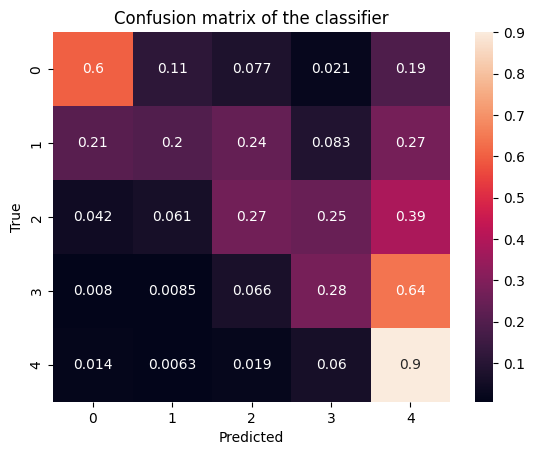

In [179]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(y_test, y_test_pred))

# Plot a confusion matrix
cm = confusion_matrix(y_test, y_test_pred, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [180]:
# TF-IDF X_submission
# Step 1: Generate the TF-IDF matrix and apply SVD
tfidf_matrix = TFIDF_Vectorization(X_submission)
tfidf_reduced = svd(tfidf_matrix)

# Step 2: Convert the reduced TF-IDF matrix to a DataFrame
tfidf_features = [f'TFIDF_{i}' for i in range(tfidf_reduced.shape[1])]  # Create column names
tfidf_reduced_df = pd.DataFrame(tfidf_reduced, columns=tfidf_features, index=X_submission.index)

# Step 3: Concatenate the reduced TF-IDF features back into X_train
X_submission_select = pd.concat([X_submission.reset_index(drop=True), tfidf_reduced_df.reset_index(drop=True)], axis=1)

# Now X_train includes the vectorized text columns as TF-IDF features
print("X_submission with TF-IDF features:", X_submission.head())

TF-IDF vectorizer fitting completed!
Dimensionality reduced to 100 components using Truncated SVD.
X_submission with TF-IDF features:         Id   ProductId          UserId  \
0  1323432  B0034G4P30  A120UTHQDQIJGH   
1  1137299  B0012IWO0I  A3SJBFCTJWBFT2   
2  1459366  B005FUTBSC  A1V6FRU7EXP6N9   
3   931601  B000AREXBU   ARXDDR76Z5Q2I   
4  1311995  B002ZG99B8   A2XAS9GVZL3B1   

                                             Summary  \
0                                  Okay for a rental   
1                                     Great for kids   
2                                         good movie   
3  Excellent quality dvd.  Don't pay big bucks fo...   
4                                     A mixed review   

                                                Text  HelpfulnessRatio  \
0  This movie was just alright for me. I think pe...         -0.953032   
1  My kids love this movie.  Exciting and fun to ...          1.431414   
2  The effects were good, not the best but far fr...  

In [181]:
X_submission_select.columns

Index(['Id', 'ProductId', 'UserId', 'Summary', 'Text', 'HelpfulnessRatio',
       'ReviewWordCount', 'ReviewCharCount', 'Polarity', 'Subjectivity',
       ...
       'TFIDF_90', 'TFIDF_91', 'TFIDF_92', 'TFIDF_93', 'TFIDF_94', 'TFIDF_95',
       'TFIDF_96', 'TFIDF_97', 'TFIDF_98', 'TFIDF_99'],
      dtype='object', length=127)

In [182]:
features = X_test.columns

X_submission_select = X_submission_select[features]

In [183]:
import pandas as pd
import numpy as np
import xgboost as xgb

# Ensure X_submission_select is in DMatrix format if using the native XGBoost API
X_submission_dmatrix = xgb.DMatrix(X_submission_select)

# Make predictions using the trained model
X_submission['Score'] = model.predict(X_submission_dmatrix)

# If model was trained on labels shifted by -1, adjust predictions by adding 1
X_submission['Score'] = X_submission['Score'] + 1

# Round the predictions to the nearest integer and clip them to the valid score range (1 to 5)
X_submission['Score'] = X_submission['Score'].round().clip(1, 5).astype(int)

# Prepare the final submission DataFrame
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)
print("Submission file created")

Submission file created
